In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
#import shutil
import geopandas as gpd
import albumentations as albu
import zipfile
from shapely.geometry import MultiPolygon, shape
from shapely.ops import transform
from pyproj import Proj, transform as coord_transform
import fiona
import rasterio
import os
import cv2
import json
import numpy as np
import geopandas as gpd
from shapely.geometry import shape
from pyproj import Proj, transform as coord_transform

In [2]:


selected_layer = 'WTR_Countywide_Stormwater_Storage'
gdb_path = "../data/KC_StormwaterDataJan2024.gdb"
layers = fiona.listlayers(gdb_path)

gdf = gpd.read_file(gdb_path, layer=selected_layer)
gdf = gdf.to_crs("EPSG:4326")
# Define the projected coordinate system (assuming it's UTM for this example)
utm_zone = 16
utm_proj = Proj(
    proj="utm",
    zone=16,
    ellps="GRS80",
    datum="NAD83",
    units="us-ft",
    preserve_units=True,
)

multipolygon_utm = gdf.geometry[0]  # Change this line for future loops
multipolygon_geom = shape(multipolygon_utm)

coordinates_list = [
    (lon, lat)
    for poly in multipolygon_geom.geoms
    for lon, lat in poly.exterior.coords
]

# Print the result
for lon, lat in coordinates_list:
    print(f"Latitude: {lat}, Longitude: {lon}")

Latitude: 41.9805658324664, Longitude: -88.47404081769909
Latitude: 41.9805596935236, Longitude: -88.47408160591796
Latitude: 41.980570589190336, Longitude: -88.47413385744332
Latitude: 41.980600963754654, Longitude: -88.47419104730466
Latitude: 41.98065450299728, Longitude: -88.47422543909526
Latitude: 41.98073122185986, Longitude: -88.47422560821568
Latitude: 41.98081900855748, Longitude: -88.47413766871533
Latitude: 41.98100686353096, Longitude: -88.47387694675203
Latitude: 41.981133814484224, Longitude: -88.47362914687746
Latitude: 41.98116817084494, Longitude: -88.47341704980938
Latitude: 41.98115861150192, Longitude: -88.47326687528322
Latitude: 41.98113188007333, Longitude: -88.47321785399552
Latitude: 41.98109905264522, Longitude: -88.47317534745427
Latitude: 41.9810479266163, Longitude: -88.47315891549547
Latitude: 41.98100772451487, Longitude: -88.47317188361038
Latitude: 41.98098332397639, Longitude: -88.47320936821198
Latitude: 41.98096009690509, Longitude: -88.473282761925

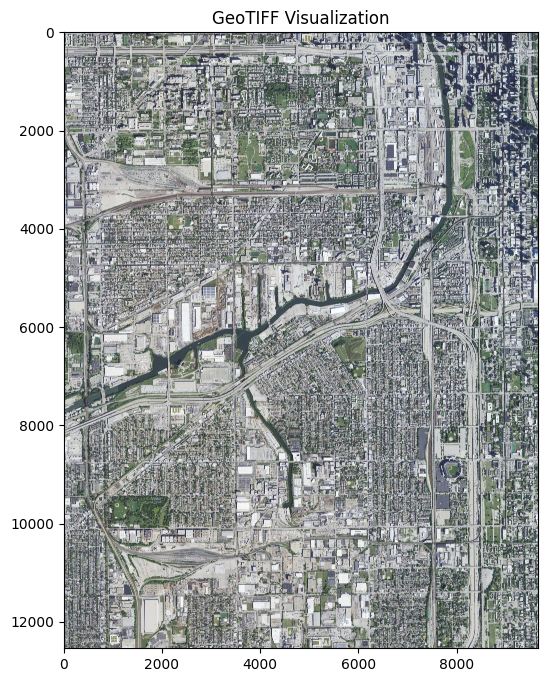

In [3]:
tif_path = '../../../../net/projects/cmap/data/GIBI-images'
with rasterio.open(tif_path + '/0.tif') as src:
    raster_data = src.read()[:3]
    raster_data = raster_data.transpose((1, 2, 0))

plt.figure(figsize=(8, 8))
plt.imshow(raster_data)
plt.title('GeoTIFF Visualization')
plt.show()

/home/rubensteinm/.conda/envs/cmap/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


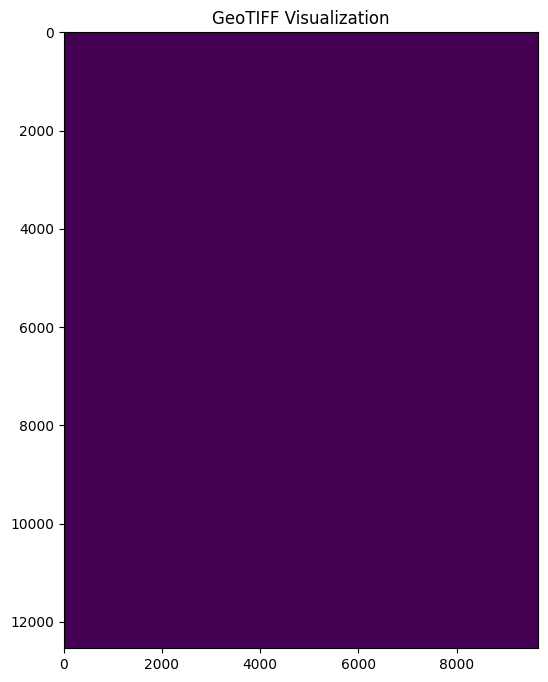

In [30]:
with rasterio.open(tif_path + '/0mask_mask.tif') as src:
    raster_data = src.read()[:3]
    raster_data = raster_data.transpose((1, 2, 0))

plt.figure(figsize=(8, 8))
plt.imshow(raster_data)
plt.title('GeoTIFF Visualization')
plt.show()

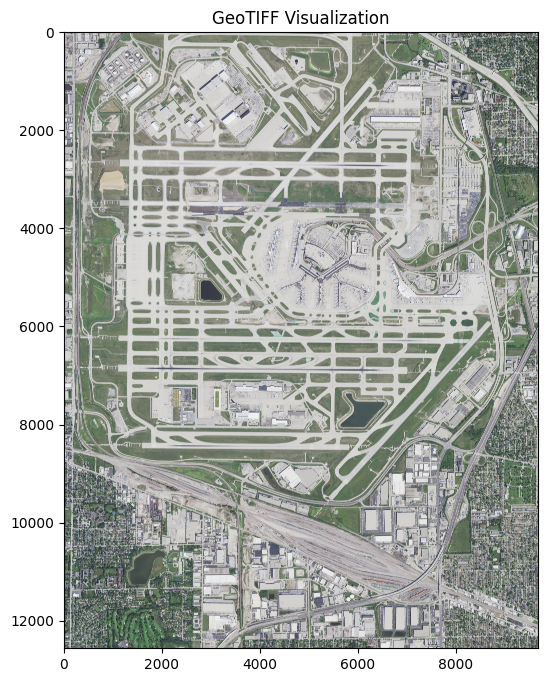

In [5]:
with rasterio.open(tif_path + '/m_4108701_ne_16_060_20210908.tif') as src:
    raster_data = src.read()[:3]
    raster_data = raster_data.transpose((1, 2, 0))

plt.figure(figsize=(8, 8))
plt.imshow(raster_data)
plt.title('GeoTIFF Visualization')
plt.show()

In [ ]:
image_path = tif_path + '/0.tif'
if image_path is None or not os.path.isfile(image_path):
    print(f"No file {image_path} found -- skipping this annotation")

src = rasterio.open(image_path)
bbox = box(*src.bounds)
print(bbox)


In [25]:
from shapely.geometry import box
tif_path = '../../../../net/projects/cmap/data/GIBI-images'

image_path = tif_path + '/../KC-images/m_4108814_ne_16_060_20210928.tif'
    # if the image does not exist, skip this annotation
if image_path is None or not os.path.isfile(image_path):
    print(f"No file {image_path} found -- skipping this annotation")

src = rasterio.open(image_path)

selected_layer = 'WTR_Countywide_Stormwater_Storage'
gdb_path = "../data/KC_StormwaterDataJan2024.gdb"
layers = fiona.listlayers(gdb_path)

gdf = gpd.read_file(gdb_path, layer=selected_layer)

bbox = box(*src.bounds)
geo_frame = gdf.copy()
print(geo_frame.geometry)
geo_frame = geo_frame.to_crs(src.crs)
print(geo_frame.geometry)
print(bbox)
geo_frame = geo_frame.drop(geo_frame[~geo_frame["geometry"].intersects(bbox)].index)

"""
It takes a GeoDataFrame that contains the annotation information
and converts each annotated picture to a mask and saves it in the directory

Parameters:
    geo_frame: GeoDataFrame that contains the information for the annotations

Returns: a list that stores the paths to all the masks
"""
print(f"processing {geo_frame}")

mask_paths = []
image_paths = []

# Iterate through each row in the GeoDataFrame
for index, row in geo_frame[:1].iterrows():
    img_annotation_chunks = row['geometry'].geoms[0].exterior.coords

    #image_path = tif_path + '/0.tif'
    # if the image does not exist, skip this annotation
    #if image_path is None or not os.path.isfile(image_path):
    #    print(f"No file {image_path} found -- skipping this annotation")
    #    continue

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    mask_path = os.path.abspath(image_path)#.replace('0.tif', '0mask.tif')
    head, tail = os.path.splitext(mask_path)
    mask_path = head + "_mask" + tail

    mask = np.zeros(img.shape[:2], np.uint8)

    #for geom in img_annotation_chunks:
    coords = np.array(img_annotation_chunks)
    coords = coords.astype(np.int32)
    print("Coor",coords)
    temp_mask = np.zeros(img.shape[:2], np.uint8)
    cv2.fillPoly(temp_mask, [coords], (255, 0, 0))
    mask = cv2.bitwise_or(mask, temp_mask)
    print("Mask type:", type(mask))
    print("MaskSum:", mask.sum())
    img[:, :] = 255
    img = cv2.bitwise_and(img, img, mask=mask)
    print("IMG type:", type(img))
    print("IMGSum:", img.sum())
    os.makedirs(os.path.dirname(mask_path), exist_ok=True)
    cv2.imwrite(mask_path, img)

    #try:
    #    change_permission(mask_path, 0o770)
    #except NotOwnerError as e:
    #    print(e)
    
    mask_paths.append(mask_path)
    image_paths.append(image_path)

#mask_paths

0       MULTIPOLYGON (((945992.273 1935539.526, 945981...
1       MULTIPOLYGON (((957439.997 1930555.492, 957416...
2       MULTIPOLYGON (((947040.816 1927034.962, 947028...
3       MULTIPOLYGON (((948408.045 1926341.826, 948397...
4       MULTIPOLYGON (((947424.509 1925889.426, 947443...
                              ...                        
5362    MULTIPOLYGON (((995094.505 1899952.507, 995098...
5363    MULTIPOLYGON (((982768.009 1889398.160, 982778...
5364    MULTIPOLYGON (((983025.852 1889423.597, 983062...
5365    MULTIPOLYGON (((985332.172 1886187.828, 985333...
5366    MULTIPOLYGON (((981011.692 1920113.693, 981016...
Name: geometry, Length: 5367, dtype: geometry
0       MULTIPOLYGON (((377884.864 4648669.285, 377881...
1       MULTIPOLYGON (((381349.384 4647096.334, 381342...
2       MULTIPOLYGON (((378164.024 4646072.932, 378160...
3       MULTIPOLYGON (((378577.339 4645855.247, 378574...
4       MULTIPOLYGON (((378275.506 4645722.062, 378281...
                          

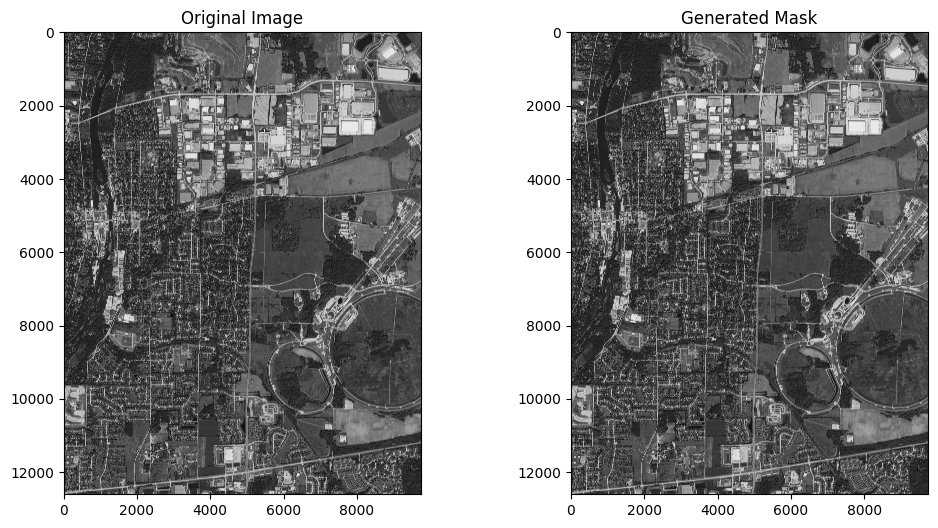

In [26]:
from matplotlib.colors import Normalize

# Function to plot images with masks
def plot_images_with_masks(original_image, mask, title_original="Original Image", title_mask="Generated Mask"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    # Plot original image
    ax1.imshow(original_image, cmap='gray')
    ax1.set_title(title_original)
    #ax1.axis('off')

    # Plot mask overlaid on the original image
    masked_image = cv2.addWeighted(original_image, 0.7, mask, 0.3, 0)
    ax2.imshow(masked_image, cmap='gray')
    ax2.set_title(title_mask)
    #ax2.axis('off')

    plt.show()

# Load the original image and the generated mask
original_image = cv2.imread(image_paths[0], cv2.IMREAD_GRAYSCALE)
generated_mask = cv2.imread(mask_paths[0], cv2.IMREAD_GRAYSCALE)

# Plot the images with masks
plot_images_with_masks(original_image, generated_mask)

In [72]:
print(mask_paths)
print(image_paths)

['/net/projects/cmap/data/KC-images/m_4108814_ne_16_060_20210928_mask.tif']
['../../../../net/projects/cmap/data/GIBI-images/../KC-images/m_4108814_ne_16_060_20210928.tif']


In [73]:
img.sum()

0

In [74]:
mask.sum()

0

In [19]:
print(geo_frame.geometry[0].geoms[0])

POLYGON ((945992.2731895857 1935539.5259302557, 945981.17937975 1935537.3071026728, 945966.9789488353 1935541.300861083, 945951.4474838339 1935552.394999005, 945942.128604833 1935571.9202224165, 945942.128604833 1935599.876859419, 945966.0914834179 1935631.8272548392, 946037.0926537514 1935700.165700838, 946104.5436343327 1935746.316527173, 946162.2318391688 1935758.7416991666, 946203.0575449169 1935755.1915094182, 946216.3701823354 1935745.4287336692, 946227.9078889191 1935733.4474584162, 946232.3452160023 1935714.809700422, 946228.7953543328 1935700.165700838, 946218.5890099183 1935691.2907185853, 946198.6198897511 1935682.8593050018, 946165.7820289172 1935679.3091152534, 946134.2752021663 1935664.6651156694, 946109.4248581678 1935649.133650668, 946072.1493421681 1935624.2833066732, 946052.1802220009 1935607.8643762544, 946037.5362224169 1935590.11408367, 946025.1110504195 1935572.3637910858, 946014.9047060013 1935559.0511536673, 946002.4795340002 1935546.6259816661, 945992.273189585

In [27]:
image_path = tif_path + '/0.tif'
    # if the image does not exist, skip this annotation
imgdf = gpd.read_file(image_path)
imgdf = imgdf.to_crs("EPSG:4326")
#img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#img.to_crs("EPSG:4326")
#with rasterio.open(tif_path + '/0.tif') as src:
#    raster_data = src.read()[:3]
#    raster_data = raster_data.transpose((1, 2, 0))

plt.figure(figsize=(8, 8))
plt.imshow(raster_data)
plt.title('GeoTIFF Visualization')
plt.show()



DriverError: '../../../../net/projects/cmap/data/GIBI-images/0.tif' not recognized as a supported file format.

In [26]:
import geopandas as gpd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

tif_path = '../../../../net/projects/cmap/data/GIBI-images'
image_path = tif_path + '/0.tif'

# Read GeoDataFrame and convert to EPSG:4326
imgdf = gpd.read_file(image_path)
imgdf = imgdf.to_crs("EPSG:4326")

# Open the GeoTIFF file using Rasterio
with rasterio.open(image_path) as src:
    # Read the raster data (first three bands for RGB)
    raster_data = src.read()[:3]

    # Transpose the data to match the order expected by matplotlib
    raster_data = raster_data.transpose((1, 2, 0))

    # Plot the GeoTIFF image using Rasterio's show function
    show(raster_data, transform=src.transform)

    # Overlay the GeoDataFrame on the plot
    imgdf.plot(ax=plt.gca(), color='none', edgecolor='red')

    # Set plot title
    plt.title('GeoTIFF Visualization with GeoDataFrame Overlay')

    # Show the plot
    plt.show()


DriverError: '../../../../net/projects/cmap/data/GIBI-images/0.tif' not recognized as a supported file format.

0         POINT (988638.445 1928138.668)
1         POINT (988517.335 1928098.592)
2         POINT (988541.793 1928133.069)
3         POINT (982974.681 1924161.306)
4         POINT (982862.712 1924227.710)
                       ...              
109169    POINT (981544.157 1920769.134)
109170    POINT (981553.490 1920776.853)
109171    POINT (981580.084 1920787.097)
109172    POINT (981582.891 1920777.905)
109173    POINT (981577.628 1920795.939)
Name: geometry, Length: 109174, dtype: geometry
0         POINT (390844.028 4646211.986)
1         POINT (390806.937 4646200.349)
2         POINT (390814.553 4646210.738)
3         POINT (389099.451 4645026.957)
4         POINT (389065.650 4645047.721)
                       ...              
109169    POINT (388647.497 4644000.158)
109170    POINT (388650.377 4644002.466)
109171    POINT (388658.529 4644005.461)
109172    POINT (388659.340 4644002.647)
109173    POINT (388657.822 4644008.166)
Name: geometry, Length: 109174, dtype: geometry
PO

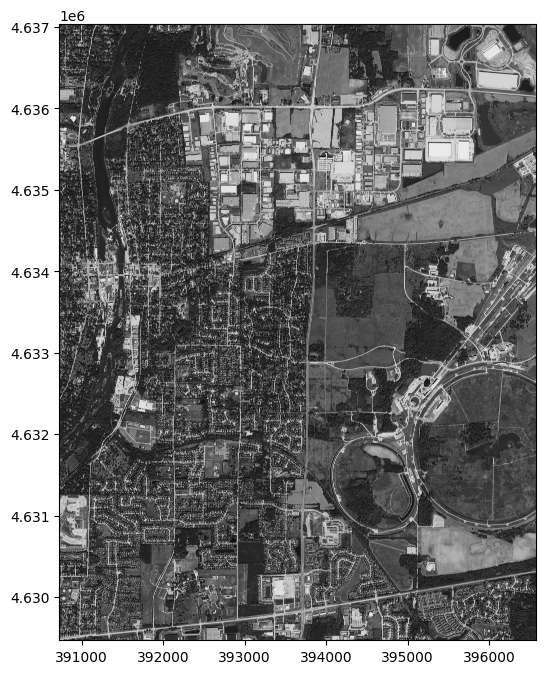

In [53]:
fp = "/net/projects/cmap/data/KC-images/m_4108814_ne_16_060_20210928.tif"
src = rasterio.open(fp)

kc = gpd.read_file("/net/projects/cmap/data/kane-county-data/KC_StormwaterDataJan2024.gdb.zip", layer=2)
print(kc.geometry)
kc = kc.to_crs(src.crs)
print(kc.geometry)
kc["STR_TYPE"].value_counts()



#fig, ax = plt.subplots(figsize=(8, 8))
#rasterio.plot.show((src, 1), ax=ax, cmap="gray")

bbox = box(*src.bounds)
print(bbox)
intersecting_pts = kc.drop(kc[~kc["geometry"].intersects(bbox)].index)
print(intersecting_pts)
#basin_types = intersecting_pts.groupby("STR_TYPE")

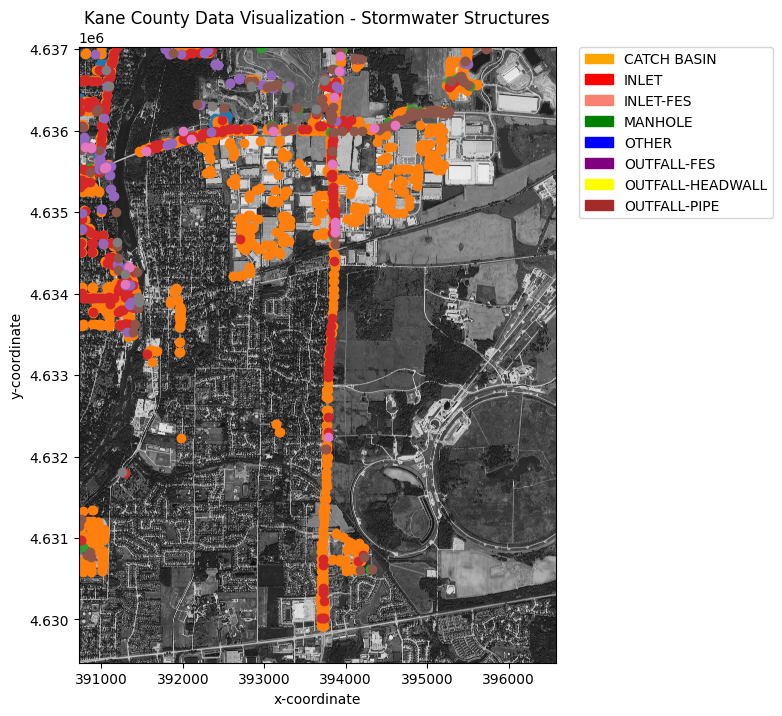

In [44]:
import rasterio.plot
import matplotlib.patches as mpatches
from shapely.geometry import box
import matplotlib.pyplot as plt
%matplotlib inline
fp = "/net/projects/cmap/data/KC-images/m_4108814_ne_16_060_20210928.tif"
src = rasterio.open(fp)

kc = gpd.read_file("/net/projects/cmap/data/kane-county-data/KC_StormwaterDataJan2024.gdb.zip", layer=2)
kc = kc.to_crs(src.crs)
kc["STR_TYPE"].value_counts()



fig, ax = plt.subplots(figsize=(8, 8))
rasterio.plot.show((src, 1), ax=ax, cmap="gray")

bbox = box(*src.bounds)
intersecting_pts = kc.drop(kc[~kc["geometry"].intersects(bbox)].index)
basin_types = intersecting_pts.groupby("STR_TYPE")

color_map = {}
patches = []
colors = ['orange', 'red', 'salmon', 'green', 'blue', 'purple', 'yellow', 'brown', 'pink', 'gray']
i = 0
for basin_type, _ in basin_types:
    color_map[basin_type] = colors[i]
    patches.append(mpatches.Patch(color=colors[i], label=basin_type))
    i += 1
for basin_type, shapes in basin_types:
    shapes.plot(ax=ax, facecolor="none", label=basin_type.lower, edgecolor=color_map[basin_type])
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")
plt.title("Kane County Data Visualization - Stormwater Structures")
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

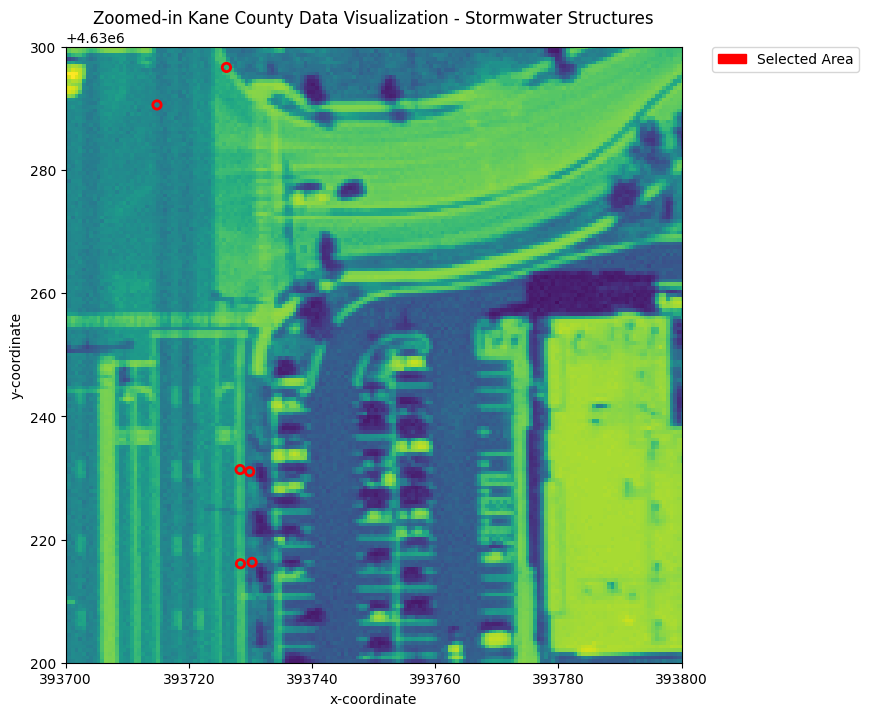

In [43]:
bbox_to_zoom = box(393700, 4630200, 393800, 4630300)  # Replace xmin, ymin, xmax, ymax with your desired coordinates

# Filter the data to include only the intersecting points within the bounding box
intersecting_pts = kc[kc["geometry"].intersects(bbox_to_zoom)]

# Create a new plot with adjusted axes limits
fig, ax = plt.subplots(figsize=(8, 8))
rasterio.plot.show((src, 1), ax=ax, )

# Plot the intersecting points within the bounding box
intersecting_pts.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=2)

# Set axes limits to focus on the specified bounding box
ax.set_xlim(393700, 393800)
ax.set_ylim(4630200 , 4630300)

# Add labels, title, and legend as before
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")
plt.title("Zoomed-in Kane County Data Visualization - Stormwater Structures")
plt.legend(handles=[mpatches.Patch(color="red", label="Selected Area")], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Show the plot
plt.show()

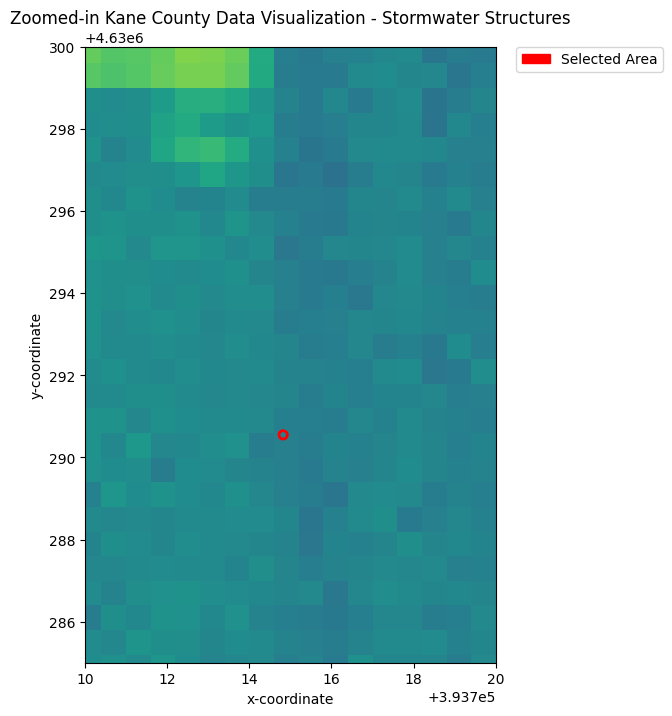

In [39]:
bbox_to_zoom = box(393710, 4630285, 393720, 4630300)  # Replace xmin, ymin, xmax, ymax with your desired coordinates

# Filter the data to include only the intersecting points within the bounding box
intersecting_pts = kc[kc["geometry"].intersects(bbox_to_zoom)]

# Create a new plot with adjusted axes limits
fig, ax = plt.subplots(figsize=(8, 8))
rasterio.plot.show((src, 1), ax=ax)

# Plot the intersecting points within the bounding box
intersecting_pts.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=2)

# Set axes limits to focus on the specified bounding box
ax.set_xlim(393710, 393720)
ax.set_ylim(4630285 , 4630300)

# Add labels, title, and legend as before
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")
plt.title("Zoomed-in Kane County Data Visualization - Stormwater Structures")
plt.legend(handles=[mpatches.Patch(color="red", label="Selected Area")], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Show the plot
plt.show()

In [32]:
kc["STR_TYPE"].value_counts()

STR_TYPE
INLET               48159
MANHOLE             27903
CATCH BASIN         20335
OUTFALL-FES          5891
OTHER                2685
INLET-FES            2656
OUTFALL-PIPE          910
OUTFALL-HEADWALL      379
OUTFALL-CHANNEL        35
OUTFALL-GRATE          15
OUTFALL TO SEWER       11
WEIR                    4
Name: count, dtype: int64

In [ ]:
import os
import cv2
import json
import numpy as np
import geopandas as gpd
from shapely.geometry import shape
from pyproj import Proj, transform as coord_transform
#from not_owner_error import NotOwnerError  # Import NotOwnerError or replace it with your error handling logic
geo_frame = gdf.copy()
"""
It takes a GeoDataFrame that contains the annotation information
and converts each annotated picture to a mask and saves it in the directory

Parameters:
    geo_frame: GeoDataFrame that contains the information for the annotations

Returns: a list that stores the paths to all the masks
"""
print(f"processing {geo_frame}")

selected_layer = 'WTR_Countywide_Stormwater_Storage'
gdb_path = "../data/KC_StormwaterDataJan2024.gdb"
layers = gpd.read_file(gdb_path, layer=selected_layer)

layers = layers.to_crs("EPSG:4326")
utm_zone = 16  # Replace with the appropriate UTM zone for your data
utm_proj = Proj(
    proj="utm",
    zone=16,
    ellps="GRS80",
    datum="NAD83",
    units="us-ft",
    preserve_units=True,
)

mask_paths = []
image_paths = []

# Iterate through each row in the GeoDataFrame
for index, row in geo_frame.iterrows():
    img_annotation_chunks = row['geometry'].geoms[0].exterior.coords
    #image_path = row['annotations']['result'][-1]['value']['text'][0].strip()
    #print(image_path)
    image_path = tif_path + '/0.tif'
    # if the image does not exist, skip this annotation
    if image_path is None or not os.path.isfile(image_path):
        print(f"No file {image_path} found -- skipping this annotation")
        continue

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    mask_path = os.path.abspath(image_path).replace('0.tif', '0mask.tif')
    head, tail = os.path.splitext(mask_path)
    mask_path = head + "_mask" + tail

    mask = np.zeros(img.shape[:2], np.uint8)

    #for coord_grp in img_annotation_chunks:
        #coords = np.array(coord_grp['value']['points'])
        #original_width = np.array(coord_grp['original_width'])
        #original_height = np.array(coord_grp['original_height'])

        #coords[:, 0] *= original_width / 100
        #coords[:, 1] *= original_height / 100
        #coords = coord_grp
        #coords = coords.astype(np.int32)
    #for geom in img_annotation_chunks:
    coords = np.array(img_annotation_chunks)
    coords = coords.astype(np.int32)
    temp_mask = np.zeros(img.shape[:2], np.uint8)
    cv2.fillPoly(temp_mask, [coords], (255, 255, 255))
    mask = cv2.bitwise_or(mask, temp_mask)

    img[:, :] = 255
    img = cv2.bitwise_and(img, img, mask=mask)

    os.makedirs(os.path.dirname(mask_path), exist_ok=True)
    cv2.imwrite(mask_path, img)

    #try:
    #    change_permission(mask_path, 0o770)
    #except NotOwnerError as e:
    #    print(e)

    mask_paths.append(mask_path)
    image_paths.append(image_path)

mask_paths


In [1]:
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [2]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [23]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['WTR_Countywide_Stormwater_Storage']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        #print("Here", self.CLASSES.index)
        #print("Next", classes)
        # convert str names to class values on masks
        #self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [24]:
f = "../../../../net/projects/cmap/data/KC-images"
#fp = "/net/projects/cmap/data/KC-images/m_4108814_ne_16_060_20210928.tif"
#src = rasterio.open(fp)

#kc = gpd.read_file("/net/projects/cmap/data/kane-county-data/KC_StormwaterDataJan2024.gdb.zip", layer=2)
#kc = kc.to_crs(src.crs)
#kc["STR_TYPE"].value_counts()
dataset = Dataset(f, f, classes=['WTR_Countywide_Stormwater_Storage'])

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

IndexError: list index out of range

In [ ]:
"../../../../net/"